In [54]:
info = """
模块 17：多 Agent 协作
学习如何创建多个专业化 Agent 并让它们协作
"""
print(info)


模块 17：多 Agent 协作
学习如何创建多个专业化 Agent 并让它们协作



In [55]:
import os
from typing import TypedDict,Annotated,Literal,List
from dotenv import load_dotenv

from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
from langchain.chat_models import init_chat_model
from langchain.agents import create_agent
from langchain.messages import HumanMessage,AIMessage,SystemMessage
from langchain.tools import tool

In [56]:
# 加载环境变量
load_dotenv()
GROQ_API_KEY = os.getenv("GROQ_API_KEY")

if not GROQ_API_KEY or GROQ_API_KEY == "your_groq_api_key_here":
    raise ValueError(
        "\n请先在 .env 文件中设置有效的 GROQ_API_KEY\n"
        "访问 https://console.groq.com/keys 获取免费密钥"
    )

In [57]:
# 初始化模型
model = init_chat_model("groq:llama-3.3-70b-versatile", api_key=GROQ_API_KEY)


In [58]:
@tool
def search_web(query: str) -> str:
    """搜索网络获取最新信息"""
    # 模拟搜索结果
    mock_results = {
        "人工智能": "人工智能(AI)是计算机科学的一个分支，致力于创建能够执行通常需要人类智能的任务的系统。主要领域包括机器学习、深度学习、自然语言处理等。",
        "机器学习": "机器学习是AI的子领域，通过算法让计算机从数据中学习。常见方法包括监督学习、无监督学习和强化学习。",
        "default": f"找到关于'{query}'的相关信息：这是一个重要的技术领域，正在快速发展中。"
    }
    for key in mock_results:
        if key in query:
            return mock_results[key]
    return mock_results["default"]


In [59]:
@tool
def check_grammar(text: str) -> str:
    """检查文本的语法和表达"""
    # 模拟语法检查
    return f"语法检查完成。文本长度：{len(text)}字符。建议：表达清晰，结构合理。"


In [60]:
print( """
    监督者模式：由一个 Supervisor 协调多个专业 Agent
    """)


    监督者模式：由一个 Supervisor 协调多个专业 Agent
    


In [61]:
print("\n" + "=" * 60)
print("示例 1：监督者模式 - 内容创作团队")
print("=" * 60)



示例 1：监督者模式 - 内容创作团队


In [62]:
# 定义状态
class TeamState(TypedDict):
    task: str
    messages: Annotated[list,add_messages]
    research_result: str
    draft: str
    final_content: str
    next_agent: str
    

In [63]:
# 监督者节点
def supervisor(state: TeamState) -> dict:
    '''监督者：决定下一步由哪个Agent处理'''
    print("  [监督者] 分析任务状态...")
    # 决策逻辑
    if not state.get("research_result"):
        next_agent = "researcher"
        print(" [监督者]决定：需要先研究 -> 分配给研究员")
    elif not state.get("draft"):
        next_agent = "writer"
        print("  [监督者] 决定：有研究结果，需要写作 -> 分配给作家")
    elif not state.get("final_content"):
        next_agent = "editor"
        print("  [监督者] 决定：有初稿，需要编辑 -> 分配给编辑")
    else:
        next_agent = "complete"
        print("  [监督者] 决定：任务完成")
    
    return {"next_agent": next_agent}

In [64]:
# 研究员 Agent
def researcher(state: TeamState) -> dict:
    """研究员：收集和整理信息"""
    print("  [研究员] 开始研究任务...")
    # 使用搜索工具
    search_result = search_web.invoke({"query":state["task"]})
    
    # 使用LLM整理信息
    messages = [
        SystemMessage(content="你是一个研究员，请根据搜索结果整理出关键信息要点。用中文回复。"),
            HumanMessage(content=f"任务：{state['task']}\n\n搜索结果：{search_result}")
    ]
    response = model.invoke(messages)
    print(f"  [研究员] 研究完成，整理了 {len(response.content)} 字的资料")
    
    return {
        "research_result": response.content,
        "messages": [AIMessage(content=f"[研究员] {response.content}")]
    }

In [65]:
# 作家 Agent
def writer(state: TeamState) -> dict:
    """作家：根据研究结果撰写内容"""
    print("  [作家] 开始撰写内容...")
    
    messages = [
        SystemMessage(content="你是一个专业作家，请根据研究资料撰写一篇结构清晰的短文。用中文写作。"),
        HumanMessage(content=f"主题：{state['task']}\n\n研究资料：{state['research_result']}")
    ]
    response = model.invoke(messages)
    
    print(f"  [作家] 完成初稿，共 {len(response.content)} 字")
    
    return {
        "draft": response.content,
        "messages": [AIMessage(content=f"[作家] {response.content}")]
    }

In [66]:
# 编辑 Agent
def editor(state: TeamState) -> dict:
    """编辑：审核和优化内容"""
    print("  [编辑] 开始审核编辑...")
    
    # 语法检查
    grammar_check = check_grammar.invoke({"text": state["draft"]})
    
    messages = [
        SystemMessage(content="你是一个资深编辑，请审核并优化以下文章，使其更加专业和易读。用中文回复。"),
        HumanMessage(content=f"初稿：{state['draft']}\n\n语法检查：{grammar_check}")
    ]
    response = model.invoke(messages)
    
    print(f"  [编辑] 编辑完成，最终版本 {len(response.content)} 字")
    
    return {
        "final_content": response.content,
        "messages": [AIMessage(content=f"[编辑] {response.content}")]
    }

In [67]:
# 路由函数
def route_to_agent(state: TeamState) -> Literal["researcher", "writer", "editor", "complete"]:
    return state["next_agent"]

In [68]:
# 构建图
graph = StateGraph(TeamState)

In [69]:
# 添加节点
graph.add_node("supervisor",supervisor)
graph.add_node("researcher",researcher)
graph.add_node("writer",writer)
graph.add_node("editor",editor)


In [70]:
# 从START 到Supervisor
graph.add_edge(START,"supervisor")
graph.add_conditional_edges(
    "supervisor",
    route_to_agent,
    {
        "researcher": "researcher",
        "writer": "writer",
        "editor": "editor",
        "complete": END   
    }                       
)

In [71]:
# 各 Agent 完成后回到 supervisor
graph.add_edge("researcher", "supervisor")
graph.add_edge("writer", "supervisor")
graph.add_edge("editor", "supervisor")


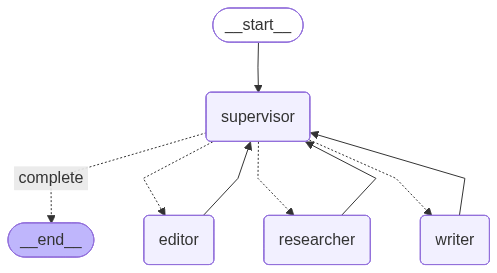

In [72]:
 # 编译并运行
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
app = graph.compile(checkpointer=memory)
app

In [73]:
config = {
    "configurable": {
        "thread_id": "user_123"
    }
}

In [74]:
result = app.invoke({
    "task": "写一篇关于人工智能发展的简短介绍",
    "messages": [HumanMessage("写一篇关于人工智能发展的简短介绍")]
},
    config=config                    
)

print("\n" + "-" * 40)
print("📝 最终内容：")
print("-" * 40)
print(result["final_content"])



  [监督者] 分析任务状态...
 [监督者]决定：需要先研究 -> 分配给研究员
  [研究员] 开始研究任务...
  [研究员] 研究完成，整理了 216 字的资料
  [监督者] 分析任务状态...
  [监督者] 决定：有研究结果，需要写作 -> 分配给作家
  [作家] 开始撰写内容...
  [作家] 完成初稿，共 262 字
  [监督者] 分析任务状态...
  [监督者] 决定：有初稿，需要编辑 -> 分配给编辑
  [编辑] 开始审核编辑...
  [编辑] 编辑完成，最终版本 861 字
  [监督者] 分析任务状态...
  [监督者] 决定：任务完成

----------------------------------------
📝 最终内容：
----------------------------------------
审阅稿：人工智能发展简介

人工智能（AI）是现代计算机科学领域的一项关键技术，旨在创建能够执行通常需要人类智能的任务的系统。人工智能的研究领域包括机器学习、深度学习和自然语言处理等。这些领域的研究目标是创建能够模拟人类智能的系统，以执行复杂任务，如学习、推理和问题解决。

人工智能的应用领域非常广泛，包括语音识别、图像识别、自动驾驶和智能助手等。这些应用已经开始改变我们的日常生活，提高生产效率和生活质量。随着人工智能技术的不断发展和改进，我们可以预见到它将在更多领域发挥重要作用，成为推动社会进步和创新的一种重要力量。

优化建议：

1. 增加引言：可以在文章开头增加一个简短的引言，解释人工智能的定义和重要性。
2. 分类应用领域：可以将应用领域分为几个类别，如工业应用、日常生活应用和医疗应用等。
3. 添加例子：可以在文章中添加一些具体的例子，说明人工智能在不同领域的应用。
4. 使用专业术语：可以使用更专业的术语，如“模式识别”和“数据分析”，来描述人工智能的应用领域。
5. 总结结论：可以在文章结尾增加一个总结结论，概括人工智能的发展和应用前景。

修订稿：

人工智能（AI）是现代计算机科学领域的一项关键技术，旨在创建能够执行通常需要人类智能的任务的系统。人工智能的研究领域包括机器学习、深度学习和自然语言处理等。这些领域的研究目标是创建能够模拟人类智能的系统，以执行复杂任务，如学习、推理和问题解决。


In [75]:
result

{'task': '写一篇关于人工智能发展的简短介绍',
 'messages': [HumanMessage(content='写一篇关于人工智能发展的简短介绍', additional_kwargs={}, response_metadata={}, id='9ffe02bc-3026-417d-a117-a1301d8df516'),
  AIMessage(content='[研究员] 以下是关于人工智能发展的简要介绍的关键信息要点：\n\n1. **定义**：人工智能（AI）是计算机科学的一个分支，旨在创建能够执行通常需要人类智能的任务的系统。\n2. **主要领域**：\n   - 机器学习\n   - 深度学习\n   - 自然语言处理\n3. **目标**：创建能够模拟人类智能的系统，以执行复杂任务，如学习、推理、解决问题等。\n4. **应用**：人工智能的应用领域广泛，包括语音识别、图像识别、自动驾驶、智能助手等。', additional_kwargs={}, response_metadata={}, id='c4282265-6fd6-41ef-91e6-356964cf0062'),
  AIMessage(content='[作家] 人工智能发展简介\n\n人工智能（AI）是现代计算机科学领域的一项重要技术，它旨在创建能够执行通常需要人类智能的任务的系统。人工智能的主要研究领域包括机器学习、深度学习和自然语言处理等。这些领域的研究目标是创建能够模拟人类智能的系统，以执行复杂任务，如学习、推理和解决问题等。\n\n人工智能的应用领域非常广泛，包括语音识别、图像识别、自动驾驶和智能助手等。这些应用已经开始改变我们的日常生活，提高生产效率和生活质量。随着人工智能技术的不断发展和改进，我们可以预见到它将在更多领域发挥重要作用，成为推动社会进步和创新的一种重要力量。', additional_kwargs={}, response_metadata={}, id='03d9133c-9f42-4617-99d1-b1542d8eb00a'),
  AIMessage(content='[编辑] 审阅稿：人工智能发展简介\n\n人工智能（AI）是现代计算机科学领域的一项关键技术，旨在创建能够执行通常需要人类智能的任务的系统。人工智能的研究领域包括机

In [76]:
print("""
    协作链模式：Agent 按顺序接力处理
    """)


    协作链模式：Agent 按顺序接力处理
    


In [77]:
print("\n" + "=" * 60)
print("示例 2：协作链模式 - 代码审查流程")
print("=" * 60)


示例 2：协作链模式 - 代码审查流程


In [78]:
class ReviewState(TypedDict):
    code: str
    messages: Annotated[list,add_messages]
    security_review: str
    performance_review: str
    style_review: str
    final_report: str
    

In [79]:
def security_reviewer(state: ReviewState) -> dict:
    '''安全审查员'''
    print("  [安全审查] 检查代码安全性...")
    messages = [
            SystemMessage(content="你是一个安全专家，请审查代码的安全性问题。用中文简洁回复。"),
            HumanMessage(content=f"代码：\n{state['code']}")
        ]
    response = model.invoke(messages)
    
    return {
        "security_review": response.content,
        "messages": [AIMessage(content=f"[安全审查] {response.content}")]
    }

In [80]:
def performance_reviewer(state: ReviewState) -> dict:
    """性能审查员"""
    print("  [性能审查] 分析代码性能...")
    
    messages = [
        SystemMessage(content="你是一个性能优化专家，请分析代码的性能问题和优化建议。用中文简洁回复。"),
        HumanMessage(content=f"代码：\n{state['code']}")
    ]
    response = model.invoke(messages)
    
    return {
        "performance_review": response.content,
        "messages": [AIMessage(content=f"[性能审查] {response.content}")]
    }

In [81]:
def style_reviewer(state: ReviewState) -> dict:
    """代码风格审查员"""
    print("  [风格审查] 检查代码风格...")
    
    messages = [
        SystemMessage(content="你是一个代码风格专家，请检查代码是否符合最佳实践。用中文简洁回复。"),
        HumanMessage(content=f"代码：\n{state['code']}")
    ]
    response = model.invoke(messages)
    
    return {
        "style_review": response.content,
        "messages": [AIMessage(content=f"[风格审查] {response.content}")]
    }


In [82]:
def report_generator(state: ReviewState) -> dict:
    """报告生成器"""
    print("  [报告生成] 汇总所有审查结果...")
    messages = [
            SystemMessage(content="你是一个技术报告撰写者，请汇总以下审查结果，生成一份简洁的审查报告。用中文回复。"),
            HumanMessage(content=f"""
安全审查结果：
{state['security_review']}

性能审查结果：
{state['performance_review']}

风格审查结果：
{state['style_review']}
""")
        ]
    response = model.invoke(messages)
    return {"final_report": response.content}

In [106]:
# 构建顺序执行的图
graph  = StateGraph(ReviewState)

In [107]:
#  添加节点
graph.add_node("security",security_reviewer)
graph.add_node("performance",performance_reviewer)
graph.add_node("style",style_reviewer)
graph.add_node("report",report_generator)

In [108]:
# 添加边
graph.add_edge(START,"security")
graph.add_edge("security","performance")
graph.add_edge("performance","style")
graph.add_edge("style","report")
graph.add_edge("report",END)

In [113]:
app  = graph.compile()
app

ValueError: Failed to reach https://mermaid.ink API while trying to render your graph. Status code: 400.

To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`

In [110]:
# 测试代码
test_code = '''
def get_user_data(user_id):
    query = f"SELECT * FROM users WHERE id = {user_id}"
    result = db.execute(query)
    data = []
    for row in result:
        data.append(row)
    return data
'''

In [111]:
result = app.invoke({
    "code": test_code,
    "messages": []
})

  [安全审查] 检查代码安全性...
  [性能审查] 分析代码性能...
  [风格审查] 检查代码风格...
  [报告生成] 汇总所有审查结果...


In [112]:
print("\n" + "-" * 40)
print("📋 代码审查报告：")
print("-" * 40)
print(result["final_report"])


----------------------------------------
📋 代码审查报告：
----------------------------------------
审查报告

### 总体评估

代码存在安全、性能和风格问题，需要进行改进以确保安全性、提高性能和遵循最佳实践。

### 安全问题

*   代码存在SQL注入漏洞，攻击者可以通过构造特定的`user_id`参数来执行任意SQL命令。
*   建议使用参数化查询来防止SQL注入，例如使用`db.execute("SELECT * FROM users WHERE id = %s", (user_id,))`。

### 性能问题

*   使用字符串格式化来构造SQL查询可能导致SQL注入攻击。
*   查询所有列（`SELECT *`）可能会返回不必要的数据，导致性能低下。
*   使用循环来将结果转换为列表可能会导致性能低下。
*   建议使用参数化查询、只查询必要的列、直接返回结果和使用ORM框架来优化性能。

### 风格问题

*   代码存在SQL注入风险、不必要的数据复制和没有错误处理的问题。
*   建议改进代码以使用参数化查询、直接返回结果集和添加错误处理。

### 改进建议

*   使用参数化查询来防止SQL注入。
*   只查询必要的列来提高性能。
*   直接返回结果集来避免不必要的数据复制。
*   添加错误处理来捕获和处理数据库错误。
*   考虑使用ORM框架来简化数据库操作和提高性能。

### 示例代码

```python
def get_user_data(user_id):
    query = "SELECT name, email FROM users WHERE id = ?"
    try:
        result = db.execute(query, (user_id,))
        return list(result)
    except db.Error as e:
        # 处理数据库错误
        print(f"数据库错误：{e}")
        return None
```

通过遵循以上建议和改进代码，可以有效地解决安全、性能和风格问题，提高代码的质量和可靠性。


In [114]:
# 动态分发模式


In [115]:
print("""
    动态分发模式：根据任务类型动态选择 Agent
    """)


    动态分发模式：根据任务类型动态选择 Agent
    


In [116]:
print("\n" + "=" * 60)
print("示例 3：动态分发模式 - 客服系统")
print("=" * 60)


示例 3：动态分发模式 - 客服系统


In [117]:
class SupportState(TypedDict):
    query: str
    category: str
    messages: Annotated[list,add_messages]
    response: str

In [126]:
def classifier(state: SupportState) -> dict:
    '''分类器： 识别问题类型'''
    print(" [分类器] 分析问题类型")
    
    messages = [
        SystemMessage(content="""分析用户问题，返回分类：
- billing：账单、付款、退款相关
- technical：技术问题、Bug、使用方法
- general：其他一般性问题
只返回分类名称，不要其他内容。"""),
        HumanMessage(content=state["query"])
    ]
    response = model.invoke(messages)
    category = response.content.strip().lower()
    # 确保返回有效分类
    if category not in ["billing", "technical", "general"]:
        category = "general"
    print(f"  [分类器] 问题分类为：{category}")
    return {"category": category}


In [127]:
def billing_agent(state: SupportState) -> dict:
    """账单客服"""
    print("  [账单客服] 处理账单问题...")
    messages = [
            SystemMessage(content="你是专业的账单客服，擅长处理付款、退款、账单查询等问题。请友好地回复用户。用中文回复。"),
            HumanMessage(content=state["query"])
        ]
    response = model.invoke(messages)
    
    return {"response": f"💰 [账单客服] {response.content}"}

In [128]:
def technical_agent(state: SupportState) -> dict:
    """技术支持"""
    print("  [技术支持] 处理技术问题...")
    
    messages = [
        SystemMessage(content="你是专业的技术支持工程师，擅长解决技术问题、Bug和使用指导。请专业地回复用户。用中文回复。"),
        HumanMessage(content=state["query"])
    ]
    response = model.invoke(messages)
    
    return {"response": f"🔧 [技术支持] {response.content}"}

In [129]:
def general_agent(state: SupportState) -> dict:
    """通用客服"""
    print("  [通用客服] 处理一般问题...")
    
    messages = [
        SystemMessage(content="你是友好的客服代表，请热情地回复用户的问题。用中文回复。"),
        HumanMessage(content=state["query"])
    ]
    response = model.invoke(messages)
    
    return {"response": f"😊 [客服] {response.content}"}

In [130]:
def route_to_specialist(state: SupportState) -> Literal["billing", "technical", "general"]:
    return state["category"]

In [131]:
# 构建图
graph = StateGraph(SupportState)



In [132]:
graph.add_node("classifier", classifier)
graph.add_node("billing", billing_agent)
graph.add_node("technical", technical_agent)
graph.add_node("general", general_agent)

In [133]:
# 添加边
graph.add_edge(START,"classifier")
graph.add_conditional_edges(
    "classifier",
    route_to_specialist,
    {
        "billing": "billing",
        "technical": "technical",
        "general": "general"
    }
)
graph.add_edge("billing", END)
graph.add_edge("technical", END)
graph.add_edge("general", END)

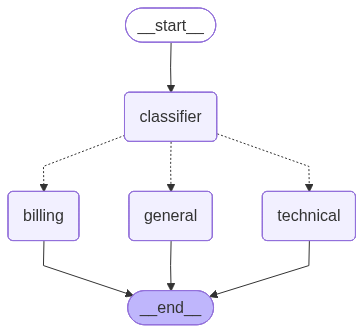

In [134]:
app = graph.compile()
app

In [135]:
# 测试不同类型的问题
test_queries = [
    "我想申请退款，上个月的订阅费用扣错了",
    "软件打开后一直显示加载中，怎么解决？",
    "你们公司在哪里？营业时间是什么？"
]


In [137]:
for query in test_queries:
    print(f"\n用户问题: {query}")
    result = app.invoke({"query": query, "messages": []})
    print(f"回复: {result['response']}")
    print("="*89)



用户问题: 我想申请退款，上个月的订阅费用扣错了
 [分类器] 分析问题类型
  [分类器] 问题分类为：billing
  [账单客服] 处理账单问题...
回复: 💰 [账单客服] 很抱歉听说您遇到了扣费错误的问题。为了更好地帮助您办理退款，请您提供以下信息：

1. 您的订阅账号或订单号。
2. 您上个月的订阅费用金额。
3. 您现在希望退款的金额是多少。

一旦我们确认您的信息，我们将尽快为您处理退款申请。同时，如果您有任何其他问题或需要更多帮助，请不要犹豫，随时与我们联系。我们会竭诚为您服务。

用户问题: 软件打开后一直显示加载中，怎么解决？
 [分类器] 分析问题类型
  [分类器] 问题分类为：technical
  [技术支持] 处理技术问题...
回复: 🔧 [技术支持] 您遇到的问题可能是由多种原因引起的，包括网络问题、软件配置问题或系统兼容性问题。以下是一些解决方案，您可以尝试：

1. **检查网络连接**：确保您的网络连接稳定且正常工作。尝试重新启动路由器或切换到不同的网络，以排除网络问题。
2. **检查软件更新**：确保您的软件版本是最新的。您可以在软件的官方网站或应用商店中检查更新。
3. **清除缓存和临时文件**：清除软件的缓存和临时文件可能可以解决问题。您可以在软件的设置中找到相关选项，或使用系统的清理工具。
4. **重置软件设置**：尝试重置软件的设置为默认值。这可能可以解决配置问题。
5. **检查系统兼容性**：确保您的操作系统和软件版本兼容。如果您使用的是较旧的系统或软件版本，可能需要升级。
6. **禁用防火墙和杀毒软件**：临时禁用防火墙和杀毒软件，以排除它们对软件的干扰。
7. **重新安装软件**：如果上述方法均无效，尝试重新安装软件。

如果您仍然遇到问题，请提供更多详细信息，例如软件名称、版本号、操作系统和错误消息，我将尽力帮助您解决问题。

用户问题: 你们公司在哪里？营业时间是什么？
 [分类器] 分析问题类型
  [分类器] 问题分类为：general
  [通用客服] 处理一般问题...
回复: 😊 [客服] 感谢您对我们的公司感兴趣！我们的公司位于中国北京市，具体地址是北京市朝阳区xxx大街xxxx号。如果您需要详细的地址信息，请告诉我，我可以为您提供。

至于营业时间，我们的办公时间是周一到